# Human Genome Language Model

# Initialisation

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
from fastai import *
from fastai.text import *
from Bio import Seq
from Bio.Seq import Seq
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.SeqFeature import FeatureLocation, CompoundLocation
import networkx as nx

In [3]:
sys.path.append("../../../Genomic-ULMFiT/")
from utils import *

In [8]:
HUMAN = Path('/home/jovyan/ml_genomics/genomeXL/data/human/')
THESIS = Path('/home/jovyan/ml_genomics/thesis/')

### Data Processing

In [ ]:
# read in chunk of 180,000 rows
df_iter = pd.read_csv(HUMAN/'human_genome_data_fa.csv', chunksize=180000)

# read to df
df = next(df_iter)

# set val to be first 20k rows
df_val = df[:20000]

df.head().Sequence[0]

len(df.head().Sequence[0])

---
# Tokenisation
### Fixed length tokenisation

In [ ]:
def generate_vocab(ngram=3, stride=1):
    """Create fixed length tokenizer, initialise databunch and return vocabulary."""
    
    # initialise tokeniser
    ngram = 3
    tok = Tokenizer(partial(GenomicTokenizer, ngram=ngram, stride=1), 
                    n_cpus=64, 
                    pre_rules=[], 
                    post_rules=[], 
                    special_cases=['xxpad'])

    data = GenomicTextLMDataBunch.from_df(
        HUMAN, df[20000:], df_val, bs=800, tokenizer=tok, 
        chunksize=10000, text_cols=0, label_cols=1, max_vocab=4^ngram)

    len(data.vocab.stoi), len(data.vocab.itos)

    # Save and load vocab
    np.save(HUMAN / 'human_vocab_3m1s.npy', data.vocab.itos)

### Variable length tokenisation

In [5]:
sys.path.append("../..")
from src.processing import process_fasta
from src.config import GRCH38_P13, GENOME

import sentencepiece as spm
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
data = process_fasta(GRCH38_P13, 10000, 2000, filter_txt='NC_')
df = pd.DataFrame(data, columns=['Sequence'])
df['Source'] = 'NCBI Human'

df.head(5000).to_csv(GENOME / 'GRCh38_p13_5000.txt', index=False)

In [13]:
SP_MODEL = str(THESIS / "models/genome10M/spiece.model")

def sp_process(data)

# makes segmenter instance and loads the model file (m.model)
sp = spm.SentencePieceProcessor()
sp.load(str(THESIS / "models/genome10M/spiece.model"))

# encode: text => id
print(sp.encode_as_pieces('GTGAAGGAGCAGGGGCTCCACGTCTGGCGACAACCAGGGAA'))
print(sp.encode_as_ids('GTGAAGGAGCAGGGGCTCCACGTCTGGCGACAACCAGGGAA'))

# decode: id => text
print(sp.decode_pieces(['▁', 'GTGA', 'AGGAG', 'CAGG', 'GGCT', 'CCAC', 'GTC', 'TGGC', 'GACA', 'ACC', 'AGGGAA']))
print(sp.decode_ids([45, 249, 203, 57, 199, 87, 72, 181, 251, 102, 520]))

True

['▁', 'GTGA', 'AGGAG', 'CAGGG', 'GCT', 'CCACG', 'TCTGG', 'C', 'GACA', 'ACCAG', 'GGAA']
[27, 61, 223, 80, 24, 382, 308, 3, 163, 259, 168]
GTGAAGGAGCAGGGGCTCCACGTCTGGCGACAACCAGGGAA
CCTGTGTGGCTGGAGTGCAAAAGBAGGAGCAGGAGCAGGCCTGGCCA


<Figure size 864x432 with 0 Axes>

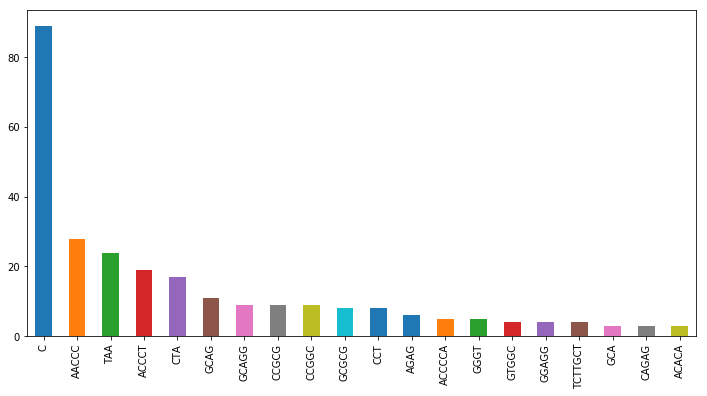

In [14]:
tokens = sp.encode_as_pieces(df.head(1).values[0][0])

plt.figure(figsize=(12,6))
pd.Series(tokens).value_counts().head(20).plot.bar()

### Comparison

In [ ]:
# Load vocab
ngram       = 3
stride      = 1
voc         = np.load(HUMAN / 'human_vocab_3m1s.npy')
model_vocab = GenomicVocab(voc)

print("Loaded vocabulary. Number of tokens: {}. Mean token length: {}.".format(len(voc), len(voc)))

In [ ]:
 # initialise tokeniser
tok = Tokenizer(partial(GenomicTokenizer, ngram=ngram, stride=1), 
                n_cpus=64, 
                pre_rules=[], 
                post_rules=[], 
                special_cases=['xxpad'])

data = GenomicTextLMDataBunch.from_df(
    HUMAN, df[20000:40000], df_val, tokenizer=tok,
    bs=3200, vocab=model_vocab, max_vocab=len(voc),
    chunksize=10000, text_cols=0, label_cols=1)

In [ ]:
data.batch_size

---
# Model initialisation

In [ ]:
config = dict(emb_sz=400, 
              n_hid=1150, 
              n_layers=3, 
              pad_token=0, 
              qrnn=False, 
              output_p=0.25, 
              hidden_p=0.1, 
              input_p=0.2, 
              embed_p=0.02, 
              weight_p=0.15, 
              tie_weights=True, 
              out_bias=True)

drop_mult=0.3

learn = get_model_LM(data, drop_mult, config)
learn = learn.to_fp16(dynamic=True); # convert model weights to 16-bit float

learn.load('human_3m1s')

In [ ]:
learn.model

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(2, 5e-3, moms=(0.8, 0.7))

In [ ]:
learn.save('human_3m1s')
learn.save_encoder('human_3m1s_enc')

---


In [ ]:
%load_ext tensorboard

In [ ]:
import fastai
fastai.__version__

In [ ]:
import tensorboardX

In [ ]:
from fastai.callbacks.tensorboard import LearnerTensorboardWriter
from fastai.callbacks.csv_logger import CSVLogger
from pathlib import Path

project_id = 'exp1'
tboard_path = Path('./logs/' + project_id)
learn.callback_fns.append(partial(LearnerTensorboardWriter, 
                                    base_dir=tboard_path, 
                                    name='run1'))

learn.callback_fns.append(partial(CSVLogger, append=True))

In [ ]:
learn.fit_one_cycle(1, 5e-3, moms=(0.8, 0.7))

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.recorder.losses

---

In [ ]:
data = GenomicTextLMDataBunch.from_df(path, df[20000:40000], df_val, bs=3000, tokenizer=tok, vocab=model_vocab, max_vocab=80000,
                              chunksize=10000, text_cols=0, label_cols=1)

config = dict(emb_sz=400, 
              n_hid=1150, 
              n_layers=3, 
              pad_token=0, 
              qrnn=False, 
              output_p=0.25, 
              hidden_p=0.1, 
              input_p=0.2, 
              embed_p=0.02, 
              weight_p=0.15, 
              tie_weights=True, 
              out_bias=True)

drop_mult=0.3

learn = get_model_LM(data, drop_mult, config)
learn = learn.to_fp16(dynamic=True);

learn.fit_one_cycle(2, 5e-3, moms=(0.8, 0.7))

In [ ]:
voc = np.load(path/'human_vocab_3m1s.npy')
model_vocab = GenomicVocab(voc)

In [ ]:
count = 0
lr = 5e-3
for df in df_iter:
    data = GenomicTextLMDataBunch.from_df(path, df, df_val, bs=800, tokenizer=tok, vocab=model_vocab, max_vocab=80000,
                                  chunksize=20000, text_cols=0, label_cols=1)
    learn.data = data                        
    lr_iter = lr/1.5**count
    print(f'Learning Rate: {lr_iter}')
    learn.fit_one_cycle(1, lr, moms=(0.8,0.7))
    count += 1

In [ ]:
learn.save('human_3m1s2')
learn.save_encoder('human_3m1s_enc2')

In [ ]:
learn.load('human_3m1s2');

In [ ]:
learn = learn.to_fp32();

In [ ]:
learn.save('human_3m1s2_fp32')